# Text Classification

It is a natural language processing notebook classifying social media messages into various categories by using multiple machine learning models.

In [ ]:
from google.colab import drive

SEED = 42
MAIN_PATH = '/content/drive'
BASE_PATH = f'{MAIN_PATH}/MyDrive/notebooks'

drive.mount(MAIN_PATH)

# LIBRARY

In [ ]:
!pip install emoji

In [ ]:
!pip install varname

In [ ]:
!pip install Distance

In [ ]:
!pip install transformers

In [ ]:
import re
import sys
import time
import torch
import emoji
import random
import pickle
import warnings
import distance
import datetime
import subprocess
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from varname import nameof
from collections import Counter
from torch import nn
from torch.optim import Adam
from torch.utils.data import (random_split,
                              TensorDataset,
                              DataLoader,
                              RandomSampler,
                              SequentialSampler)
from transformers import (pipeline,
                          AutoTokenizer,
                          AutoModelForTokenClassification,
                          BertModel,
                          BertTokenizer,
                          BertForSequenceClassification,
                          AdamW,
                          BertConfig,
                          get_linear_schedule_with_warmup)
from sklearn.svm import LinearSVC
from sklearn.utils import class_weight
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import (accuracy_score,
                             recall_score,
                             precision_score,
                             f1_score, make_scorer,
                             classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV)
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
sys.path.insert(0, f'{BASE_PATH}/external_modules/turkish_lemmatizer')

%cd drive/MyDrive/notebooks/external_modules/turkish_lemmatizer

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4d584ce1-b981-76e0-3fd0-9d872812cc20)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
if tf.test.gpu_device_name() == '/device:GPU:0':
  device = torch.device('cuda')
else:
  raise Exception('GPU not found!')

# DATA

In [ ]:
df = pd.DataFrame()

## Social Media

In [ ]:
df_social_media_train = pd.read_csv(f'{BASE_PATH}/data/social-media-train.csv')

df_social_media_train.head(3)

In [ ]:
df_social_media_valid = pd.read_csv(f'{BASE_PATH}/data/social-media-valid.csv')

df_social_media_valid.head(3)

In [ ]:
df_social_media_test = pd.read_csv(f'{BASE_PATH}/data/social-media-test.csv')

df_social_media_test.head(3)

In [ ]:
df_social_media = pd.concat([df_social_media_train, df_social_media_test, df_social_media_valid])

df_social_media.head(3)

In [ ]:
df_social_media_train.shape, df_social_media_test.shape, df_social_media_valid.shape, df_social_media.shape

((4683, 2), (586, 2), (585, 2), (5854, 2))

In [ ]:
df = pd.concat([df, df_social_media])

## Eksisozluk

In [ ]:
df_eksisozluk = pd.read_csv(f'{BASE_PATH}/data/eksisozluk.csv', sep=';')

df_eksisozluk.head(3)

In [ ]:
df_eksisozluk = df_eksisozluk[['Pred Label', 'Text']].copy()

df_eksisozluk.rename(columns={'Pred Label': 'label', 'Text': 'text'}, inplace=True)

df_eksisozluk.head(3)

In [ ]:
df_eksisozluk.shape

(3517, 2)

In [ ]:
df = pd.concat([df, df_eksisozluk])

## Sikayetvar

In [ ]:
df_sikayetvar = pd.read_csv(f'{BASE_PATH}/data/sikayetvar.csv', sep=';')

df_sikayetvar.head(3)

In [ ]:
df_sikayetvar = df_sikayetvar[['Pred Label', 'Text']].copy()

df_sikayetvar.rename(columns={'Pred Label': 'label', 'Text': 'text'}, inplace=True)

df_sikayetvar.head(3)

In [ ]:
df_sikayetvar.shape

(20779, 2)

In [ ]:
df = pd.concat([df, df_sikayetvar])

## Comments

In [ ]:
df_comments_train = pd.read_csv(f'{BASE_PATH}/data/comments-train.csv')

df_comments_train.head(3)

In [ ]:
df_comments_test = pd.read_csv(f'{BASE_PATH}/data/comments-test.csv')

df_comments_test.head(3)

In [ ]:
df_comments_valid = pd.read_csv(f'{BASE_PATH}/data/comments-valid.csv')

df_comments_valid.head(3)

In [ ]:
df_comments = pd.concat([df_comments_train, df_comments_test, df_comments_valid])

df_comments.head(3)

In [ ]:
df_comments_train.shape, df_comments_test.shape, df_comments_valid.shape, df_comments.shape

((786, 6), (99, 6), (98, 6), (983, 6))

In [ ]:
df_comments = df_comments[['text', 'label1']].copy()

df_comments.rename(columns={'label1': 'label'}, inplace=True)

df_comments.head(3)

In [ ]:
df = pd.concat([df, df_comments])

## Final Data

In [ ]:
df.shape

(31133, 2)

In [ ]:
df.isna().sum()

text        0
label    1316
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.drop_duplicates(subset='text', keep='last', inplace=True)

In [ ]:
df = df[df['text'].str.strip().str.split().str.len().gt(2)]

In [ ]:
df['label'].unique()

array(['kurye-şikayeti', 'yanlış-ürün', 'gec-teslimat',
       'tarihi-geçmiş-ürün', 'uygulama-hatası-donma', 'siparis-iptali',
       'kampanya-kullanamama', 'eksik-ürün', 'reklam-elestirisi',
       'bozuk-ürün', 'musteri-hizmetleri', 'hizmet-alanı',
       'diger-kurumsal', 'yogunluk', 'fiyat', 'odeme-geri-odeme-sikayeti',
       'kampanya kullanamama', 'reklam eleştirisi', 'diğer/kurumsal',
       'hizmet alanı', 'ödeme/geri ödeme şikayeti', 'müşteri hizmetleri',
       'sipariş iptali', 'ürün şikayeti', 'geç teslimat',
       'trafik kuralı ihlali', 'yoğunluk', 'uygulama hatası/donma',
       'eksik ürün', 'kurye şikayeti', 'maskesiz kurye',
       'reklam-eleştirisi', 'müşteri-hizmetleri', 'geç-teslimat',
       'ürün-şikayeti', 'diğer-kurumsal', 'sipariş-iptali',
       'ödeme-geri-ödeme-şikayeti'], dtype=object)

In [ ]:
label_mapping = {
    'ödeme/geri ödeme şikayeti': 'odeme-geri-odeme-sikayeti',
    'ödeme-geri-ödeme-şikayeti': 'odeme-geri-odeme-sikayeti',
    'ürün şikayeti': 'urun-sikayeti',
    'ürün-şikayeti': 'urun-sikayeti',
    'geç teslimat': 'gec-teslimat',
    'geç-teslimat': 'gec-teslimat',
    'müşteri hizmetleri': 'musteri-hizmetleri',
    'müşteri-hizmetleri': 'musteri-hizmetleri',
    'kampanya kullanamama': 'kampanya-kullanamama',
    'eksik ürün': 'eksik-urun',
    'eksik-ürün': 'eksik-urun',
    'sipariş iptali': 'siparis-iptali',
    'sipariş-iptali': 'siparis-iptali',
    'uygulama hatası/donma': 'uygulama-hatasi-donma',
    'uygulama-hatası-donma': 'uygulama-hatasi-donma',
    'kurye-şikayeti': 'kurye-sikayeti',
    'kurye şikayeti': 'kurye-sikayeti',
    'diğer/kurumsal': 'diger-kurumsal',
    'diğer-kurumsal': 'diger-kurumsal',
    'yoğunluk': 'yogunluk',
    'reklam-eleştirisi': 'reklam-elestirisi',
    'reklam eleştirisi': 'reklam-elestirisi',
    'hizmet alanı': 'hizmet-alani',
    'hizmet-alanı': 'hizmet-alani',
    'bozuk-ürün': 'urun-sikayeti',
    'tarihi-geçmiş-ürün': 'urun-sikayeti',
    'trafik kuralı ihlali': 'kurye-sikayeti',
    'maskesiz kurye': 'kurye-sikayeti',
    'kurye-sikayeti': 'calisan-sikayeti',
    'yanlış-ürün': 'eksik-urun'
}

df['label'] = df['label'].replace(label_mapping)

In [ ]:
df['label'].value_counts()

odeme-geri-odeme-sikayeti    5318
urun-sikayeti                3979
gec-teslimat                 3916
musteri-hizmetleri           3488
kampanya-kullanamama         3009
eksik-urun                   2471
siparis-iptali               2294
diger-kurumsal               1006
calisan-sikayeti              893
uygulama-hatasi-donma         840
fiyat                         788
yogunluk                      709
reklam-elestirisi             380
hizmet-alani                  293
Name: label, dtype: int64

In [ ]:
df.to_csv(f'{BASE_PATH}/data/final-data.csv', index=False)

# PREPROCESSING

In [ ]:
df = pd.read_csv(f'{BASE_PATH}/data/final-data.csv')

df.head(3)

In [ ]:
df.shape

(29384, 2)

In [ ]:
# Reference: https://www.turkceogretimi.com/genel-konular/turkce-etkisiz-kelimeler-stop-words-listesi-11
# Reference: https://github.com/tkorkunckaya/Turkish-Stopwords/blob/master/stopwords/postgresql/turkish.stop
sw = pd.read_csv(f'{BASE_PATH}/data/stopwords.txt', names=['stopword'])

sw.head(3)

,stopword
0,ara
1,ama
2,amma


In [ ]:
preprocessing_test = 'https://terlik.tr   -->   Hey يٰسٓ !!! Yüksek kalite ve uygun fiyat ile @terlik alışverişine hazır mısın? 🔥 Son tarih 12 Eylül...'

In [ ]:
def remove_link(data, replacement=' '):
  return re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, data.lower().strip())

remove_link(preprocessing_test)

'    -->   hey يٰسٓ !!! yüksek kalite ve uygun fiyat ile @terlik alışverişine hazır mısın? 🔥 son tarih 12 eylül...'

In [ ]:
def remove_mention(data, replacement=' '):
  return re.sub('@[^\s]+', replacement, data.lower().strip())

remove_mention(preprocessing_test)

'https://terlik.tr   -->   hey يٰسٓ !!! yüksek kalite ve uygun fiyat ile   alışverişine hazır mısın? 🔥 son tarih 12 eylül...'

In [ ]:
def remove_emoji(data, replacement=' '):
  return emoji.replace_emoji(data.lower().strip(), replace=replacement)

remove_emoji(preprocessing_test)

'https://terlik.tr   -->   hey يٰسٓ !!! yüksek kalite ve uygun fiyat ile @terlik alışverişine hazır mısın?   son tarih 12 eylül...'

In [ ]:
def remove_nonlatin(data, replacement=' '):
  return re.sub('[^\\x00-\\x7F\\x80-\\xFF\\u0100-\\u017F\\u0180-\\u024F\\u1E00-\\u1EFF]', replacement, data.lower().strip())

remove_nonlatin(preprocessing_test)

'https://terlik.tr   -->   hey      !!! yüksek kalite ve uygun fiyat ile @terlik alışverişine hazır mısın?   son tarih 12 eylül...'

In [ ]:
def remove_nonword(data, replacement=' '):
  return re.sub('\W', replacement, data.lower().strip())

remove_nonword(preprocessing_test)

'https   terlik tr         hey ي س      yüksek kalite ve uygun fiyat ile  terlik alışverişine hazır mısın    son tarih 12 eylül   '

In [ ]:
def remove_digit(data, replacement=' '):
  return re.sub('\d+', replacement, data.lower().strip())

remove_digit(preprocessing_test)

'https://terlik.tr   -->   hey يٰسٓ !!! yüksek kalite ve uygun fiyat ile @terlik alışverişine hazır mısın? 🔥 son tarih   eylül...'

In [ ]:
def remove_stopword(data, replacement=' '):
  return replacement.join([i for i in data.lower().strip().split() if i not in sw.stopword.values])

remove_stopword(preprocessing_test)

'https://terlik.tr --> hey يٰسٓ !!! yüksek kalite uygun fiyat @terlik alışverişine hazır mısın? 🔥 tarih 12 eylül...'

In [ ]:
def remove_whitespace(data, replacement=' '):
  return re.sub(' +', replacement, data.lower().strip())

remove_whitespace(preprocessing_test)

'https://terlik.tr --> hey يٰسٓ !!! yüksek kalite ve uygun fiyat ile @terlik alışverişine hazır mısın? 🔥 son tarih 12 eylül...'

In [ ]:
def preprocess(data):
  data = remove_link(data)
  data = remove_mention(data)
  data = remove_emoji(data)
  data = remove_nonlatin(data)
  data = remove_nonword(data)
  data = remove_digit(data)
  data = remove_stopword(data)
  data = remove_whitespace(data)
  return data

preprocess(preprocessing_test)

'hey yüksek kalite uygun fiyat alışverişine hazır mısın tarih eylül'

In [ ]:
df['text_preprocessed'] = df.apply(lambda row: preprocess(row['text']), axis=1)

df.head(3)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.to_csv(f'{BASE_PATH}/data/final-data-preprocessed.csv', index=False)

# PROCESSING

In [ ]:
df = pd.read_csv(f'{BASE_PATH}/data/final-data-preprocessed.csv')

df.head(3)

In [ ]:
df.shape

(29384, 3)

In [ ]:
# Reference: https://huggingface.co/savasy/bert-base-turkish-ner-cased
# Reference: https://huggingface.co/akdeniz27/bert-base-turkish-cased-ner
ner = pipeline(
    'ner',
    model=AutoModelForTokenClassification.from_pretrained('savasy/bert-base-turkish-ner-cased'),
    tokenizer=AutoTokenizer.from_pretrained('savasy/bert-base-turkish-ner-cased'),
    aggregation_strategy='first'
)

In [ ]:
ner_test = "Mopaş'taki Ali İhsan, Huawei uygulamanızdan verdiğim Şubat tarihli siparişimi getir yoksa siparişi Getir'den veririm"

In [ ]:
ner(ner_test)

[{'entity_group': 'ORG',
  'score': 0.6101202,
  'word': 'Mopaş',
  'start': 0,
  'end': 5},
 {'entity_group': 'PER',
  'score': 0.7814659,
  'word': 'Ali İhsan',
  'start': 11,
  'end': 20},
 {'entity_group': 'ORG',
  'score': 0.9750981,
  'word': 'Huawei',
  'start': 22,
  'end': 28},
 {'entity_group': 'ORG',
  'score': 0.5519802,
  'word': 'Getir',
  'start': 99,
  'end': 104}]

In [ ]:
def apply_ner(data, threshold=0.45):
  shift = 0
  for entity in ner(data):
    if entity['score'] >= threshold:
      start, end = entity['start'], entity['end']
      group = f"<{entity['entity_group']}>"

      if shift != 0:
        start += shift
        end += shift

      data = ''.join([data[:start], group, data[end:]])

      if len(group) != len(entity['word']):
        shift += len(group) - len(entity['word'])

  data = ' '.join(['_' + re.search(r'.*?\<(.*)>.*', i).group(1) if '<' in i else i for i in data.split(' ')])
  return data

In [ ]:
lemma_test = apply_ner(ner_test)

lemma_test

'_ORG _PER _ORG uygulamanızdan verdiğim Şubat tarihli siparişimi getir yoksa siparişi _ORG veririm'

In [ ]:
# Reference: https://github.com/akoksal/Turkish-Lemmatizer
!python3 trainLexicon.py

Negative verbs are added.
Zero infinitive forms of verbs are added.
Consonant softening forms are added.
Dropping vowel forms are added.
Becoming close vowel forms are added.
Transformed lexicon is saved to revisedDict.pkl


In [ ]:
lemma_out = subprocess.run(['python3', 'lemmatizer.py', 'uygulamanızdan'], capture_output=True).stdout
lemma_out.decode('utf-8').split('\n')[1]

'uygulama_1'

In [ ]:
def apply_lemma(data):
  lemma_data = []
  for word in data.split(' '):
    if len(word) > 0 and word[0] != '_':
      lemma_result = subprocess.run(['python3', 'lemmatizer.py', word], capture_output=True).stdout
      word = lemma_result.decode('utf-8').split('\n')[1][:-2]
    lemma_data.append(word)

  data = ' '.join(lemma_data)
  return data

apply_lemma(lemma_test)

'_ORG _PER _ORG uygulama verdi şubat tarih sipariş getir yoksa sipariş _ORG veri'

In [ ]:
def process(data):
  if not data or np.isnan(data):
    return None

  data = apply_ner(data)
  data = apply_lemma(data)
  return data

process(ner_test)

'_ORG _PER _ORG uygulama verdi şubat tarih sipariş getir yoksa sipariş _ORG veri'

In [ ]:
df['text_processed'] = df.apply(lambda row: process(row['text_preprocessed']), axis=1)

df.head(3)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.to_csv(f'{BASE_PATH}/data/final-data-processed.csv', index=False)

# MODEL

In [ ]:
df = pd.read_csv(f'{BASE_PATH}/data/final-data-processed.csv')

df.head(3)

In [ ]:
df.shape

(29323, 5)

## Scikit-learn

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text_processed'].values, df['label'].values, test_size=0.2, random_state=SEED, stratify=df['label'].values)

X_train.shape, X_test.shape

((23458,), (5865,))

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.7, ngram_range=(1, 2))
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

In [ ]:
class_names = np.unique(y_train)
class_weights = class_weight.compute_class_weight('balanced', classes=class_names, y=y_train)
class_weights_map = {class_names[i]: class_weights[i] for i in range(len(class_names))}

class_weights_map

{'calisan-sikayeti': 2.3834586466165413,
 'diger-kurumsal': 2.084044065387349,
 'eksik-urun': 0.8479612492770388,
 'fiyat': 2.6809142857142856,
 'gec-teslimat': 0.5353263350068462,
 'hizmet-alani': 7.160561660561661,
 'kampanya-kullanamama': 0.6975734506958488,
 'musteri-hizmetleri': 0.600563236047107,
 'odeme-geri-odeme-sikayeti': 0.39443771859026094,
 'reklam-elestirisi': 5.585238095238095,
 'siparis-iptali': 0.9131179447255742,
 'urun-sikayeti': 0.5274068078600657,
 'uygulama-hatasi-donma': 2.5008528784648187,
 'yogunluk': 2.970871327254306}

In [ ]:
def apply_finetuning(model, parameters):
  f1_scorer = make_scorer(f1_score, average='macro')
  classifier = RandomizedSearchCV(model, parameters, scoring=f1_scorer, cv=3, n_iter=10)
  classifier.fit(tfidf_train_vectors, y_train)
  return classifier.best_params_

apply_finetuning(RandomForestClassifier(), {'max_features': ['auto', 'sqrt']})

{'max_features': 'auto'}

In [ ]:
def apply_training(model):
  classifier = model.fit(tfidf_train_vectors, y_train)
  y_pred = classifier.predict(tfidf_test_vectors)
  metrics = classification_report(y_test, y_pred, output_dict=True)
  metrics['weighted avg']['accuracy'] = accuracy_score(y_test, y_pred)
  return metrics['weighted avg']

apply_training(RandomForestClassifier())

{'precision': 0.6985224759683004,
 'recall': 0.7014492753623188,
 'f1-score': 0.6910365002489357,
 'support': 5865,
 'accuracy': 0.7014492753623188}

In [ ]:
def import_model(model_name):
  return pickle.load(open(f'{BASE_PATH}/models/{}.pkl'.format(model_name), 'rb'))

In [ ]:
def export_model(model, model_name):
  pickle.dump(model, open(f'{BASE_PATH}/models/{}.pkl'.format(model_name), 'wb'))

### Random Forest

In [ ]:
apply_finetuning(
    RandomForestClassifier(random_state=SEED, class_weight=class_weights_map),
    {
      'max_features': [None, 'sqrt', 'log2'],
      'criterion' :['gini', 'entropy', 'log_loss'],
      'n_estimators': [10, 100, 1000],
      'max_depth': [None, 5, 10, 25],
      'min_samples_leaf': [2, 5, 10]
    }
)

In [ ]:
model_rf = RandomForestClassifier(
    random_state=SEED,
    class_weight=class_weights_map,
    n_estimators=1000,
    min_samples_leaf=5,
    max_features='sqrt',
    max_depth=None,
    criterion='entropy'
)
metrics_rf = apply_training(model_rf)

metrics_rf

(0.6830349531116795,
 {'precision': 0.7007979918904781,
  'recall': 0.6830349531116795,
  'f1-score': 0.6812205134395151,
  'support': 5865})

In [ ]:
export_model(model_rf, nameof(model_rf))

### Support Vector

In [ ]:
apply_finetuning(
    LinearSVC(random_state=SEED, class_weight=class_weights_map),
    {
      'penalty': ['l1', 'l2'],
      'loss': ['hinge', 'squared_hinge'],
      'C': [1, 10, 100, 1000]
    }
)

In [ ]:
model_svc = LinearSVC(
    random_state=SEED,
    class_weight=class_weights_map,
    penalty='l2',
    loss='hinge',
    C=1
)
metrics_svc = apply_training(model_svc)

metrics_svc

(0.7439045183290708,
 {'precision': 0.7481595666456362,
  'recall': 0.7439045183290708,
  'f1-score': 0.7435817812128073,
  'support': 5865})

In [ ]:
export_model(model_svc, nameof(model_svc))

### Logistic Regression

In [ ]:
apply_finetuning(
    LogisticRegression(random_state=SEED, class_weight=class_weights_map),
    {
      'penalty': [None, 'elasticnet', 'l1', 'l2'],
      'C': [1, 10, 100, 1000],
      'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
      'max_iter': [10, 100, 1000]
    }
)

In [ ]:
model_lr = LogisticRegression(
    random_state=SEED,
    class_weight=class_weights_map,
    solver='newton-cg',
    penalty='l2',
    max_iter=100,
    C=10
)
metrics_lr = apply_training(model_lr)

metrics_lr

(0.7473145780051151,
 {'precision': 0.7525132855904909,
  'recall': 0.7473145780051151,
  'f1-score': 0.7490537196715227,
  'support': 5865})

In [ ]:
export_model(model_lr, nameof(model_lr))

## BERT

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(df['label'])
df['label_encode'] = label_encoder.transform(df['label'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text_processed'], df['label_encode'], test_size=0.2, random_state=SEED)

X_train.shape, X_test.shape

((23458,), (5865,))

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-uncased', do_lower_case=True)

In [ ]:
input_ids = []
attention_masks = []

for x in X_train.values:
    encoded_dict = bert_tokenizer.encode_plus(
        x,
        add_special_tokens=True,
        max_length=280,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

labels = torch.tensor(y_train.values)

In [ ]:
train_set = TensorDataset(input_ids, attention_masks, labels)
train_dl = DataLoader(train_set, sampler=RandomSampler(train_set), batch_size=20)

model = BertForSequenceClassification.from_pretrained(
    'dbmdz/bert-base-turkish-uncased',
    num_labels=len(df['label_encode'].unique()),
    output_attentions=False,
    output_hidden_states=False
)
model.cuda()

In [ ]:
epoch = 5
bert_optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, num_warmup_steps=0, num_training_steps=len(train_dl) * epoch)

In [ ]:
train_t0 = time.time()

train_stats = []

for epoch_i in range(epoch):
    print('===== Epoch {:} / {:} ====='.format(epoch_i + 1, epoch))

    t0 = time.time()
    train_loss = 0

    model.train()

    for step, batch in enumerate(train_dl):
        if step % 10 == 0 and not step == 0:
            t = str(datetime.timedelta(seconds=int(round((time.time() - t0)))))
            print('Batch {:>5,} of {:>5,}. Time: {:}.'.format(step, len(train_dl), t))

        batch_input_ids = batch[0].to(device)
        batch_input_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        model.zero_grad()
        output = model(
            batch_input_ids,
            token_type_ids=None,
            attention_mask=batch_input_mask,
            labels=batch_labels
        )
        loss = output['loss']
        logits = output['logits']
        train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        bert_optimizer.step()
        bert_scheduler.step()

    avg_loss = train_loss / len(train_dl)
    print('Avg. Training Loss: {0:.2f}'.format(avg_loss))

    epoch_t = int(round((time.time() - t0)))
    print('Epoch Training Time (sec.): {:}'.format(epoch_t))

    train_stats.append({'epoch': epoch_i + 1, 'loss': avg_loss, 't': epoch_t})

print('Training completed in {:} sec.'.format(int(round((time.time() - train_t0)))))

In [ ]:
input_ids = []
attention_masks = []

for x in X_test.values:
    encoded_dict = bert_tokenizer.encode_plus(
        x,
        add_special_tokens=True,
        max_length=280,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

labels = torch.tensor(y_test.values)

pred = TensorDataset(input_ids, attention_masks, labels)
pred_dl = DataLoader(pred, sampler=SequentialSampler(pred), batch_size=20)

In [ ]:
model.eval()

preds, true_labels = [], []

for batch in pred_dl:
  batch = tuple(t.to(device) for t in batch)
  batch_input_ids, batch_input_mask, batch_labels = batch

  with torch.no_grad():
      outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  preds.append(logits)

  label_ids = batch_labels.to('cpu').numpy()
  true_labels.append(label_ids)

In [ ]:
preds_set = []

for i in range(len(true_labels)):
  preds_labels_i = np.argmax(preds[i], axis=1).flatten()
  preds_set.append(preds_labels_i)

preds_scores = [i for sub_set in preds_set for i in sub_set]

In [ ]:
print('precision:', precision_score(y_test.values, preds_scores, average='weighted'))
print('recall:', recall_score(y_test.values, preds_scores, average='weighted'))
print('f1-Score:', f1_score(y_test.values, preds_scores, average='weighted'))

precision: 0.7845511678154728
recall: 0.7853367433930094
f1-Score: 0.7847354607008051


In [ ]:
label_encoder_map = dict(zip(
    label_encoder.classes_,
    label_encoder.transform(label_encoder.classes_)
))

label_encoder_map

{'calisan-sikayeti': 0,
 'diger-kurumsal': 1,
 'eksik-urun': 2,
 'fiyat': 3,
 'gec-teslimat': 4,
 'hizmet-alani': 5,
 'kampanya-kullanamama': 6,
 'musteri-hizmetleri': 7,
 'odeme-geri-odeme-sikayeti': 8,
 'reklam-elestirisi': 9,
 'siparis-iptali': 10,
 'urun-sikayeti': 11,
 'uygulama-hatasi-donma': 12,
 'yogunluk': 13}

In [ ]:
bert_report = pd.DataFrame(classification_report(y_test.values, preds_scores, output_dict=True))
bert_report = bert_report.rename(columns={str(v): k for k, v in label_encoder_map.items()})

bert_report

,calisan-sikayeti,diger-kurumsal,eksik-urun,fiyat,gec-teslimat,hizmet-alani,kampanya-kullanamama,musteri-hizmetleri,odeme-geri-odeme-sikayeti,reklam-elestirisi,siparis-iptali,urun-sikayeti,uygulama-hatasi-donma,yogunluk,accuracy,macro avg,weighted avg
precision,0.743750,0.495000,0.793372,0.682171,0.765182,0.642857,0.851419,0.715134,0.852087,0.813333,0.776908,0.874065,0.634731,0.691176,0.785337,0.737942,0.784551
recall,0.753165,0.490099,0.820565,0.628571,0.758021,0.631579,0.841584,0.696532,0.867036,0.762500,0.820248,0.872976,0.654321,0.610390,0.785337,0.729113,0.785337
f1-score,0.748428,0.492537,0.806739,0.654275,0.761585,0.637168,0.846473,0.705710,0.859497,0.787097,0.797990,0.873520,0.644377,0.648276,0.785337,0.733119,0.784735
support,158.000000,202.000000,496.000000,140.000000,748.000000,57.000000,606.000000,692.000000,1083.000000,80.000000,484.000000,803.000000,162.000000,154.000000,0.785337,5865.000000,5865.000000


In [ ]:
torch.save(model, f'{BASE_PATH}/models/bert.pt')

## LSTM

In [ ]:
label_count = df['label'].nunique()

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(df['label'])
df['label_encode'] = label_encoder.transform(df['label'])

In [ ]:
df = df[['text_processed', 'label_encode']]
df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)

df_train.shape, df_test.shape

((23458, 2), (5865, 2))

In [ ]:
train_labels = tf.squeeze(tf.constant([df_train.pop('label_encode')]), axis=0)
train_set = tf.data.Dataset.from_tensor_slices((dict(df_train)['text_processed'], train_labels))

train_set.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [ ]:
test_labels = tf.squeeze(tf.constant([df_test.pop('label_encode')]), axis=0)
test_set = tf.data.Dataset.from_tensor_slices((dict(df_test)['text_processed'], test_labels))

test_set.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [ ]:
train_set = train_set.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
test_set = test_set.batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
for text, label in train_set.take(1):
  print(text.numpy()[0].decode('utf-8'))
  print(label.numpy()[0])

mükemmel
3


In [ ]:
word_counter = Counter()
df['text_processed'].str.lower().str.split().apply(word_counter.update)

len(word_counter.keys()), len({k: v for k, v in word_counter.items() if v > 5})

(9881, 4237)

In [ ]:
lstm_encoder = tf.keras.layers.TextVectorization(max_tokens=4000)
lstm_encoder.adapt(train_set.map(lambda text, label: text))

In [ ]:
lstm_vocab = np.array(lstm_encoder.get_vocabulary())

lstm_vocab[:5]

array(['', '[UNK]', 'sipariş', 'ol', 'org'], dtype='<U16')

In [ ]:
lstm_model = tf.keras.Sequential([
    lstm_encoder,
    tf.keras.layers.Embedding(
        input_dim=len(lstm_encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(label_count, activation='softmax')
])

In [ ]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          256000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 14)                1806      
                                                                 
Total params: 323,854
Trainable params: 323,854
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
lstm_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
lstm_history = lstm_model.fit(train_set, epochs=10, validation_data=test_set, callbacks=[lstm_es])

Epoch 1/10
367/367 [==============================] - 640s 2s/step - loss: 1.6517 - accuracy: 0.4482 - val_loss: 1.2163 - val_accuracy: 0.6036
Epoch 2/10
367/367 [==============================] - 573s 2s/step - loss: 1.0052 - accuracy: 0.6789 - val_loss: 0.9228 - val_accuracy: 0.6957
Epoch 3/10
367/367 [==============================] - 546s 1s/step - loss: 0.7845 - accuracy: 0.7484 - val_loss: 0.8675 - val_accuracy: 0.7158
Epoch 4/10
367/367 [==============================] - 546s 1s/step - loss: 0.6650 - accuracy: 0.7862 - val_loss: 0.8516 - val_accuracy: 0.7258
Epoch 5/10
367/367 [==============================] - 537s 1s/step - loss: 0.5929 - accuracy: 0.8117 - val_loss: 0.8758 - val_accuracy: 0.7229
Epoch 6/10
367/367 [==============================] - 550s 1s/step - loss: 0.5284 - accuracy: 0.8309 - val_loss: 0.8811 - val_accuracy: 0.7236
Epoch 7/10
367/367 [==============================] - 563s 2s/step - loss: 0.4888 - accuracy: 0.8427 - val_loss: 0.9001 - val_accuracy: 0.7257

In [ ]:
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(test_set)

print('test loss:', lstm_test_loss)
print('test accuracy:', lstm_test_acc)

92/92 [==============================] - 11s 113ms/step - loss: 0.9001 - accuracy: 0.7257
test loss: 0.9000843167304993
test accuracy: 0.7256606817245483


In [ ]:
lstm_model.save(f'{BASE_PATH}/models/lstm', overwrite=True)

# RESULT

In [ ]:
value_mappings = {
    'odeme-geri-odeme-sikayeti': 'payment issue',
    'urun-sikayeti': 'product complaint',
    'gec-teslimat': 'late delivery',
    'musteri-hizmetleri': 'customer services',
    'kampanya-kullanamama': 'gratitude',
    'eksik-urun': 'missing product',
    'siparis-iptali': 'order cancellation',
    'diger-kurumsal': 'others',
    'calisan-sikayeti': 'complaint about employee',
    'uygulama-hatasi-donma': 'application error',
    'fiyat': 'price',
    'yogunluk': 'campaign problem',
    'reklam-elestirisi': 'advertisement criticism',
    'hizmet-alani': 'service area'
}
df['label'] = df['label'].map(value_mappings)

df.head(3)

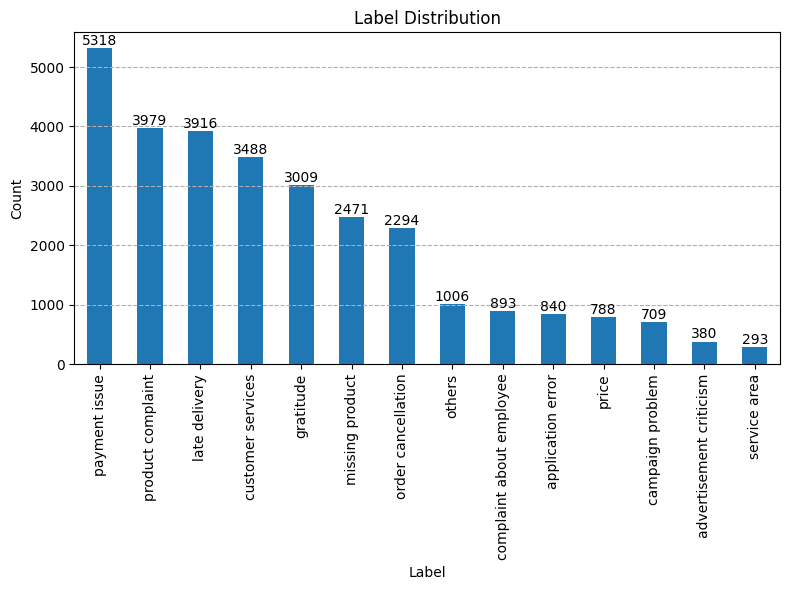

In [ ]:
category_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
ax = category_counts.plot(kind='bar')
ax.grid(True, linestyle='--', axis='y')
for i, count in enumerate(category_counts):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.tight_layout()
plt.show()